In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=600 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,55,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 5)
Dimension - total coordinates:  (6000, 55)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 55, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,55,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer')(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 600)   3000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 600)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 16200)        0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230102\\3Case(131415)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_3Case(131415)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1702 - rmse: 0.4124
Epoch 1: val_loss improved from inf to 0.12624, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 16s 113ms/step - loss: 0.1664 - rmse: 0.4078 - val_loss: 0.1262 - val_rmse: 0.3551 - lr: 1.0000e-04
Epoch 2/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.1026 - rmse: 0.3200
Epoch 2: val_loss improved from 0.12624 to 0.05987, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 33ms/step - loss: 0.0929 - rmse: 0.3045 - val_loss: 0.0599 - val_rmse: 0.2444 - lr: 1.0000e-04
Epoch 3/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0659 - rmse: 0.2564
Epoch 3: val_loss improved from

Epoch 23/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0601 - rmse: 0.2449
Epoch 23: val_loss did not improve from 0.05706
10/10 [==============================] - 0s 13ms/step - loss: 0.0576 - rmse: 0.2397 - val_loss: 0.0572 - val_rmse: 0.2389 - lr: 1.0000e-04
Epoch 24/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0595 - rmse: 0.2437
Epoch 24: val_loss improved from 0.05706 to 0.05688, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 39ms/step - loss: 0.0566 - rmse: 0.2376 - val_loss: 0.0569 - val_rmse: 0.2382 - lr: 1.0000e-04
Epoch 25/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0597 - rmse: 0.2440
Epoch 25: val_loss did not improve from 0.05688
10/10 [==============================] - 0s 13ms/step - loss: 0.0597 - rmse: 0.2440 - val_loss: 0.0570 - val_rmse: 0.2384 - lr: 1.0000e-

10/10 [==============================] - 0s 33ms/step - loss: 0.0540 - rmse: 0.2321 - val_loss: 0.0537 - val_rmse: 0.2313 - lr: 1.0000e-04
Epoch 45/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0546 - rmse: 0.2333
Epoch 45: val_loss improved from 0.05366 to 0.05343, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 33ms/step - loss: 0.0541 - rmse: 0.2324 - val_loss: 0.0534 - val_rmse: 0.2308 - lr: 1.0000e-04
Epoch 46/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0516 - rmse: 0.2269
Epoch 46: val_loss improved from 0.05343 to 0.05291, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 33ms/step - loss: 0.0532 - rmse: 0.2304 - val_loss: 0.0529 - val_rmse: 0.2

10/10 [==============================] - 0s 40ms/step - loss: 0.0238 - rmse: 0.1537 - val_loss: 0.0206 - val_rmse: 0.1428 - lr: 1.0000e-04
Epoch 64/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0193 - rmse: 0.1385
Epoch 64: val_loss improved from 0.02055 to 0.01760, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 38ms/step - loss: 0.0193 - rmse: 0.1386 - val_loss: 0.0176 - val_rmse: 0.1321 - lr: 1.0000e-04
Epoch 65/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0161 - rmse: 0.1264
Epoch 65: val_loss improved from 0.01760 to 0.01510, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 39ms/step - loss: 0.0165 - rmse: 0.1278 - val_loss: 0.0151 - val_rmse: 0.1

Epoch 84/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0025 - rmse: 0.0486
Epoch 84: val_loss improved from 0.00268 to 0.00234, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0025 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 85/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0023 - rmse: 0.0459
Epoch 85: val_loss improved from 0.00234 to 0.00215, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 38ms/step - loss: 0.0024 - rmse: 0.0473 - val_loss: 0.0022 - val_rmse: 0.0448 - lr: 1.0000e-04
Epoch 86/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0021 - rmse: 0.0443
Epoch 86: val_loss impro

 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0328
Epoch 106: val_loss did not improve from 0.00112
10/10 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0337 - val_loss: 0.0013 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 107/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0014 - rmse: 0.0357
Epoch 107: val_loss did not improve from 0.00112
10/10 [==============================] - 0s 13ms/step - loss: 0.0015 - rmse: 0.0362 - val_loss: 0.0014 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 108/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0015 - rmse: 0.0373
Epoch 108: val_loss did not improve from 0.00112
10/10 [==============================] - 0s 13ms/step - loss: 0.0015 - rmse: 0.0371 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 109/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0316    
Epoch 109: val_loss improved from 0.00112 to 0.00089, saving model t

Epoch 130/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.9082e-04 - rmse: 0.0212
Epoch 130: val_loss improved from 0.00060 to 0.00057, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 5.9630e-04 - rmse: 0.0213 - val_loss: 5.6760e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 131/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.4361e-04 - rmse: 0.0224
Epoch 131: val_loss did not improve from 0.00057
10/10 [==============================] - 0s 12ms/step - loss: 6.5574e-04 - rmse: 0.0227 - val_loss: 7.1669e-04 - val_rmse: 0.0240 - lr: 1.0000e-04
Epoch 132/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.7717e-04 - rmse: 0.0232
Epoch 132: val_loss did not improve from 0.00057
10/10 [==============================] - 0s 12ms/step - loss: 6.7851e-04 - rmse: 0.0232 - val_loss: 5.

10/10 [==============================] - 0s 34ms/step - loss: 5.4927e-04 - rmse: 0.0203 - val_loss: 4.5031e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 156/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.4683e-04 - rmse: 0.0202
Epoch 156: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 12ms/step - loss: 5.4024e-04 - rmse: 0.0201 - val_loss: 4.8109e-04 - val_rmse: 0.0185 - lr: 1.0000e-04
Epoch 157/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6712e-04 - rmse: 0.0182
Epoch 157: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 12ms/step - loss: 4.7150e-04 - rmse: 0.0183 - val_loss: 4.8200e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 158/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.2860e-04 - rmse: 0.0198
Epoch 158: val_loss improved from 0.00045 to 0.00045, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1

 7/10 [====================>.........] - ETA: 0s - loss: 4.6831e-04 - rmse: 0.0183
Epoch 180: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 12ms/step - loss: 4.6971e-04 - rmse: 0.0183 - val_loss: 4.9788e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 181/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.1777e-04 - rmse: 0.0196
Epoch 181: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 12ms/step - loss: 5.1224e-04 - rmse: 0.0194 - val_loss: 4.6847e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 182/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.3901e-04 - rmse: 0.0201
Epoch 182: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 12ms/step - loss: 5.2711e-04 - rmse: 0.0198 - val_loss: 5.8528e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 183/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.2260e-04 - rmse: 0.0197
Epoch 183: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 4.6264e-04 - rmse: 0.0182
Epoch 207: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 4.8131e-04 - rmse: 0.0187 - val_loss: 5.4366e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 208/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.7592e-04 - rmse: 0.0211
Epoch 208: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 5.6151e-04 - rmse: 0.0208 - val_loss: 6.1296e-04 - val_rmse: 0.0220 - lr: 1.0000e-04
Epoch 209/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.5536e-04 - rmse: 0.0206
Epoch 209: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 5.2706e-04 - rmse: 0.0199 - val_loss: 5.5421e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 210/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.5814e-04 - rmse: 0.0207
Epoch 210: val_loss did not impr

Epoch 235/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.4155e-04 - rmse: 0.0204
Epoch 235: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 5.5152e-04 - rmse: 0.0206 - val_loss: 7.3769e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 236/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.7709e-04 - rmse: 0.0235
Epoch 236: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 6.4921e-04 - rmse: 0.0229 - val_loss: 4.8465e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 237/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.7632e-04 - rmse: 0.0212
Epoch 237: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 5.6187e-04 - rmse: 0.0209 - val_loss: 4.8640e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 238/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.9665e-04 - rmse: 0.0192
Epoch 238: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 4.0776e-04 - rmse: 0.0169
Epoch 262: val_loss improved from 0.00036 to 0.00035, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 32ms/step - loss: 3.9573e-04 - rmse: 0.0165 - val_loss: 3.4773e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 263/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3918e-04 - rmse: 0.0178
Epoch 263: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 13ms/step - loss: 4.8223e-04 - rmse: 0.0189 - val_loss: 4.0864e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 264/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5184e-04 - rmse: 0.0181
Epoch 264: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 13ms/step - loss: 4.5447e-04 - rmse: 0.0182 - val_loss: 3.6261e-04 - val_r

Epoch 289/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4850e-04 - rmse: 0.0181
Epoch 289: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 4.8208e-04 - rmse: 0.0190 - val_loss: 6.5415e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 290/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0708e-04 - rmse: 0.0197
Epoch 290: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 5.2720e-04 - rmse: 0.0202 - val_loss: 6.6364e-04 - val_rmse: 0.0233 - lr: 1.0000e-04
Epoch 291/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.5066e-04 - rmse: 0.0208
Epoch 291: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 5.2843e-04 - rmse: 0.0202 - val_loss: 3.9495e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 292/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1050e-04 - rmse: 0.0171
Epoch 292: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.8937e-04 - rmse: 0.0165
Epoch 316: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 4.2070e-04 - rmse: 0.0174 - val_loss: 4.1079e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 317/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0233e-04 - rmse: 0.0169
Epoch 317: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.9986e-04 - rmse: 0.0168 - val_loss: 3.5947e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 318/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8427e-04 - rmse: 0.0164
Epoch 318: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 4.0815e-04 - rmse: 0.0171 - val_loss: 5.4687e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 319/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.0951e-04 - rmse: 0.0198
Epoch 319: val_loss did not impr

 8/10 [=======================>......] - ETA: 0s - loss: 3.9351e-04 - rmse: 0.0167
Epoch 343: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.9849e-04 - rmse: 0.0169 - val_loss: 4.2356e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 344/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.4771e-04 - rmse: 0.0183
Epoch 344: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 4.3940e-04 - rmse: 0.0181 - val_loss: 5.4225e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 345/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6562e-04 - rmse: 0.0188
Epoch 345: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 10ms/step - loss: 4.5826e-04 - rmse: 0.0186 - val_loss: 3.7330e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 346/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1145e-04 - rmse: 0.0173
Epoch 346: val_loss did not impr

Epoch 371/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.7902e-04 - rmse: 0.0192
Epoch 371: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 5.0531e-04 - rmse: 0.0199 - val_loss: 5.3261e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 372/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.0883e-04 - rmse: 0.0245
Epoch 372: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 7.2321e-04 - rmse: 0.0248 - val_loss: 7.8741e-04 - val_rmse: 0.0260 - lr: 1.0000e-04
Epoch 373/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.3881e-04 - rmse: 0.0251
Epoch 373: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 6.9821e-04 - rmse: 0.0242 - val_loss: 8.6339e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 374/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2897e-04 - rmse: 0.0268
Epoch 374: val_l

Epoch 399/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7901e-04 - rmse: 0.0165
Epoch 399: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.7635e-04 - rmse: 0.0164 - val_loss: 3.1746e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 400/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.0790e-04 - rmse: 0.0173
Epoch 400: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 10ms/step - loss: 4.1339e-04 - rmse: 0.0175 - val_loss: 3.2268e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 401/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.9085e-04 - rmse: 0.0168
Epoch 401: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.8760e-04 - rmse: 0.0167 - val_loss: 3.7397e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 402/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.9585e-04 - rmse: 0.0170
Epoch 402: val_l

Epoch 426/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1328e-04 - rmse: 0.0176
Epoch 426: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.1088e-04 - rmse: 0.0175 - val_loss: 4.4395e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 427/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.7054e-04 - rmse: 0.0191
Epoch 427: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.6927e-04 - rmse: 0.0191 - val_loss: 5.2042e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 428/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3559e-04 - rmse: 0.0182
Epoch 428: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.3430e-04 - rmse: 0.0182 - val_loss: 3.0456e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 429/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6598e-04 - rmse: 0.0190
Epoch 429: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.7977e-04 - rmse: 0.0167
Epoch 453: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 3.7352e-04 - rmse: 0.0165 - val_loss: 3.0802e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 454/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4977e-04 - rmse: 0.0157
Epoch 454: val_loss improved from 0.00029 to 0.00029, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 3.3832e-04 - rmse: 0.0154 - val_loss: 2.8952e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 455/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5131e-04 - rmse: 0.0158
Epoch 455: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 3.5385e-04 - rmse: 0.0159 - val_loss: 3.0897e-04 - val_r

 7/10 [====================>.........] - ETA: 0s - loss: 3.8169e-04 - rmse: 0.0168
Epoch 480: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.7761e-04 - rmse: 0.0167 - val_loss: 2.9732e-04 - val_rmse: 0.0140 - lr: 1.0000e-04
Epoch 481/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2672e-04 - rmse: 0.0181
Epoch 481: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.6033e-04 - rmse: 0.0190 - val_loss: 3.9305e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 482/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8425e-04 - rmse: 0.0196
Epoch 482: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.6510e-04 - rmse: 0.0191 - val_loss: 3.6167e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 483/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0018e-04 - rmse: 0.0173
Epoch 483: val_loss did not impr

Epoch 508/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3164e-04 - rmse: 0.0183
Epoch 508: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 4.3294e-04 - rmse: 0.0183 - val_loss: 3.7514e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 509/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.4267e-04 - rmse: 0.0186
Epoch 509: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 10ms/step - loss: 4.3259e-04 - rmse: 0.0183 - val_loss: 4.7192e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 510/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.7144e-04 - rmse: 0.0193
Epoch 510: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.7624e-04 - rmse: 0.0195 - val_loss: 5.3809e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 511/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.9637e-04 - rmse: 0.0200
Epoch 511: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 4.5498e-04 - rmse: 0.0190
Epoch 535: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 4.5111e-04 - rmse: 0.0189 - val_loss: 3.7051e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 536/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4639e-04 - rmse: 0.0158
Epoch 536: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.6750e-04 - rmse: 0.0165 - val_loss: 3.6180e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 537/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5038e-04 - rmse: 0.0188
Epoch 537: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.4427e-04 - rmse: 0.0187 - val_loss: 4.0715e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 538/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8775e-04 - rmse: 0.0171
Epoch 538: val_loss did not impr

Epoch 563/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4728e-04 - rmse: 0.0159
Epoch 563: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.4296e-04 - rmse: 0.0158 - val_loss: 2.9442e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 564/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.6863e-04 - rmse: 0.0194
Epoch 564: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 4.6691e-04 - rmse: 0.0193 - val_loss: 3.9046e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 565/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.2188e-04 - rmse: 0.0207
Epoch 565: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 5.1076e-04 - rmse: 0.0204 - val_loss: 5.5810e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 566/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.3858e-04 - rmse: 0.0186
Epoch 566: val_l

Epoch 590/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0945e-04 - rmse: 0.0178
Epoch 590: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.0374e-04 - rmse: 0.0177 - val_loss: 3.1908e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 591/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5059e-04 - rmse: 0.0161
Epoch 591: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.3490e-04 - rmse: 0.0156 - val_loss: 3.5104e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 592/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9513e-04 - rmse: 0.0174
Epoch 592: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.8383e-04 - rmse: 0.0171 - val_loss: 2.9974e-04 - val_rmse: 0.0144 - lr: 1.0000e-04
Epoch 593/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3609e-04 - rmse: 0.0156
Epoch 593: val_l

10/10 [==============================] - 0s 13ms/step - loss: 3.2472e-04 - rmse: 0.0153 - val_loss: 3.0100e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 617/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2346e-04 - rmse: 0.0153
Epoch 617: val_loss improved from 0.00028 to 0.00026, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 34ms/step - loss: 3.1690e-04 - rmse: 0.0151 - val_loss: 2.6364e-04 - val_rmse: 0.0132 - lr: 5.0000e-05
Epoch 618/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9652e-04 - rmse: 0.0144
Epoch 618: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 13ms/step - loss: 2.9899e-04 - rmse: 0.0145 - val_loss: 2.6395e-04 - val_rmse: 0.0132 - lr: 5.0000e-05
Epoch 619/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3406e-04 - rmse: 0.0156
Epoc

 7/10 [====================>.........] - ETA: 0s - loss: 3.1115e-04 - rmse: 0.0149
Epoch 643: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.0156e-04 - rmse: 0.0146 - val_loss: 2.7684e-04 - val_rmse: 0.0137 - lr: 5.0000e-05
Epoch 644/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0070e-04 - rmse: 0.0145
Epoch 644: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.1893e-04 - rmse: 0.0152 - val_loss: 2.8769e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 645/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8829e-04 - rmse: 0.0141
Epoch 645: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.0098e-04 - rmse: 0.0146 - val_loss: 2.7287e-04 - val_rmse: 0.0136 - lr: 5.0000e-05
Epoch 646/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9436e-04 - rmse: 0.0143
Epoch 646: val_loss did not impr

Epoch 671/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5329e-04 - rmse: 0.0163
Epoch 671: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.4371e-04 - rmse: 0.0160 - val_loss: 2.7983e-04 - val_rmse: 0.0138 - lr: 5.0000e-05
Epoch 672/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3089e-04 - rmse: 0.0156
Epoch 672: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.2422e-04 - rmse: 0.0154 - val_loss: 2.7159e-04 - val_rmse: 0.0135 - lr: 5.0000e-05
Epoch 673/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0413e-04 - rmse: 0.0147
Epoch 673: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.0431e-04 - rmse: 0.0147 - val_loss: 2.7834e-04 - val_rmse: 0.0138 - lr: 5.0000e-05
Epoch 674/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4652e-04 - rmse: 0.0161
Epoch 674: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.6252e-04 - rmse: 0.0166
Epoch 698: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.4490e-04 - rmse: 0.0161 - val_loss: 2.9066e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 699/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1976e-04 - rmse: 0.0153
Epoch 699: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.2052e-04 - rmse: 0.0153 - val_loss: 2.7914e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 700/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4423e-04 - rmse: 0.0160
Epoch 700: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.3489e-04 - rmse: 0.0157 - val_loss: 3.1023e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 701/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2590e-04 - rmse: 0.0155
Epoch 701: val_loss did not impr

Epoch 726/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1638e-04 - rmse: 0.0152
Epoch 726: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.2974e-04 - rmse: 0.0156 - val_loss: 2.8095e-04 - val_rmse: 0.0140 - lr: 5.0000e-05
Epoch 727/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0385e-04 - rmse: 0.0148
Epoch 727: val_loss improved from 0.00026 to 0.00026, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 3.3091e-04 - rmse: 0.0156 - val_loss: 2.5828e-04 - val_rmse: 0.0131 - lr: 5.0000e-05
Epoch 728/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4254e-04 - rmse: 0.0160
Epoch 728: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.3322e-04 - rmse: 0.0157 - val_loss: 3.

 8/10 [=======================>......] - ETA: 0s - loss: 3.3100e-04 - rmse: 0.0157
Epoch 753: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.4074e-04 - rmse: 0.0160 - val_loss: 3.5153e-04 - val_rmse: 0.0163 - lr: 5.0000e-05
Epoch 754/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5999e-04 - rmse: 0.0166
Epoch 754: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.5200e-04 - rmse: 0.0163 - val_loss: 3.5764e-04 - val_rmse: 0.0165 - lr: 5.0000e-05
Epoch 755/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.5939e-04 - rmse: 0.0166
Epoch 755: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.6303e-04 - rmse: 0.0167 - val_loss: 2.8383e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 756/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4368e-04 - rmse: 0.0161
Epoch 756: val_loss did not impr

Epoch 781/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3500e-04 - rmse: 0.0158
Epoch 781: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.4567e-04 - rmse: 0.0162 - val_loss: 3.3604e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 782/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7059e-04 - rmse: 0.0169
Epoch 782: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.4840e-04 - rmse: 0.0162 - val_loss: 3.3087e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 783/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2991e-04 - rmse: 0.0157
Epoch 783: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.2750e-04 - rmse: 0.0156 - val_loss: 2.8253e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 784/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3949e-04 - rmse: 0.0160
Epoch 784: val_l

Epoch 809/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3332e-04 - rmse: 0.0158
Epoch 809: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.3936e-04 - rmse: 0.0160 - val_loss: 2.6133e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 810/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0073e-04 - rmse: 0.0147
Epoch 810: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.9886e-04 - rmse: 0.0147 - val_loss: 2.7544e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 811/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9558e-04 - rmse: 0.0146
Epoch 811: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.8982e-04 - rmse: 0.0144 - val_loss: 2.6172e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 812/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4239e-04 - rmse: 0.0161
Epoch 812: val_l

10/10 [==============================] - 0s 11ms/step - loss: 2.9747e-04 - rmse: 0.0146 - val_loss: 2.5319e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 836/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9891e-04 - rmse: 0.0147
Epoch 836: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 10ms/step - loss: 2.9376e-04 - rmse: 0.0145 - val_loss: 2.5117e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 837/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9422e-04 - rmse: 0.0145
Epoch 837: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 2.9132e-04 - rmse: 0.0144 - val_loss: 2.5134e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 838/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1209e-04 - rmse: 0.0151
Epoch 838: val_loss improved from 0.00025 to 0.00025, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1

Epoch 863/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8597e-04 - rmse: 0.0143
Epoch 863: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.9087e-04 - rmse: 0.0144 - val_loss: 2.7892e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 864/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3582e-04 - rmse: 0.0159
Epoch 864: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.3248e-04 - rmse: 0.0158 - val_loss: 2.7002e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 865/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1229e-04 - rmse: 0.0152
Epoch 865: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.1211e-04 - rmse: 0.0151 - val_loss: 2.5379e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 866/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9003e-04 - rmse: 0.0144
Epoch 866: val_l

Epoch 891/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.1698e-04 - rmse: 0.0153
Epoch 891: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 10ms/step - loss: 3.1472e-04 - rmse: 0.0152 - val_loss: 2.6850e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 892/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5648e-04 - rmse: 0.0166
Epoch 892: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 3.5316e-04 - rmse: 0.0165 - val_loss: 4.0199e-04 - val_rmse: 0.0179 - lr: 2.5000e-05
Epoch 893/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8775e-04 - rmse: 0.0175
Epoch 893: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.6961e-04 - rmse: 0.0170 - val_loss: 2.7106e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 894/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2140e-04 - rmse: 0.0155
Epoch 894: val_l

Epoch 919/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3050e-04 - rmse: 0.0158
Epoch 919: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.1856e-04 - rmse: 0.0154 - val_loss: 2.9393e-04 - val_rmse: 0.0146 - lr: 2.5000e-05
Epoch 920/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1502e-04 - rmse: 0.0153
Epoch 920: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.2391e-04 - rmse: 0.0156 - val_loss: 2.6139e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 921/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4000e-04 - rmse: 0.0161
Epoch 921: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.3911e-04 - rmse: 0.0160 - val_loss: 2.9284e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 922/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1905e-04 - rmse: 0.0154
Epoch 922: val_l

Epoch 947/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0285e-04 - rmse: 0.0149
Epoch 947: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 2.9556e-04 - rmse: 0.0146 - val_loss: 2.6338e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 948/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9875e-04 - rmse: 0.0147
Epoch 948: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 2.9222e-04 - rmse: 0.0145 - val_loss: 2.5713e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 949/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8434e-04 - rmse: 0.0143
Epoch 949: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 10ms/step - loss: 2.8912e-04 - rmse: 0.0144 - val_loss: 2.6068e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 950/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3538e-04 - rmse: 0.0159
Epoch 950: val_l

Epoch 975/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2720e-04 - rmse: 0.0157
Epoch 975: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.1851e-04 - rmse: 0.0154 - val_loss: 2.6050e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 976/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9225e-04 - rmse: 0.0145
Epoch 976: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.9335e-04 - rmse: 0.0146 - val_loss: 2.6092e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 977/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1711e-04 - rmse: 0.0154
Epoch 977: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.1405e-04 - rmse: 0.0153 - val_loss: 2.7081e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 978/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9964e-04 - rmse: 0.0148
Epoch 978: val_l

Epoch 1003/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9099e-04 - rmse: 0.0145
Epoch 1003: val_loss improved from 0.00025 to 0.00025, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_600kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 2.9983e-04 - rmse: 0.0148 - val_loss: 2.4547e-04 - val_rmse: 0.0128 - lr: 2.5000e-05
Epoch 1004/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7513e-04 - rmse: 0.0140
Epoch 1004: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.9377e-04 - rmse: 0.0146 - val_loss: 2.5221e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 1005/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9454e-04 - rmse: 0.0146
Epoch 1005: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.9357e-04 - rmse: 0.0146 - val_lo

Epoch 1030/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5699e-04 - rmse: 0.0133
Epoch 1030: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.5713e-04 - rmse: 0.0133 - val_loss: 2.4667e-04 - val_rmse: 0.0129 - lr: 1.2500e-05
Epoch 1031/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9641e-04 - rmse: 0.0147
Epoch 1031: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.0094e-04 - rmse: 0.0149 - val_loss: 2.4778e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 1032/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.7235e-04 - rmse: 0.0139
Epoch 1032: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 2.7060e-04 - rmse: 0.0138 - val_loss: 2.5317e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1033/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9180e-04 - rmse: 0.0146
Epoch 103

Epoch 1058/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8330e-04 - rmse: 0.0143
Epoch 1058: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.7856e-04 - rmse: 0.0141 - val_loss: 2.6196e-04 - val_rmse: 0.0135 - lr: 1.2500e-05
Epoch 1059/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9320e-04 - rmse: 0.0146
Epoch 1059: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.9507e-04 - rmse: 0.0147 - val_loss: 2.6252e-04 - val_rmse: 0.0135 - lr: 1.2500e-05
Epoch 1060/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9183e-04 - rmse: 0.0146
Epoch 1060: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.8270e-04 - rmse: 0.0142 - val_loss: 2.5642e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 1061/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9148e-04 - rmse: 0.0145
Epoch 106

Epoch 1086/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0445e-04 - rmse: 0.0150
Epoch 1086: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 3.0074e-04 - rmse: 0.0149 - val_loss: 2.6622e-04 - val_rmse: 0.0137 - lr: 1.2500e-05
Epoch 1087/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9855e-04 - rmse: 0.0148
Epoch 1087: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.9516e-04 - rmse: 0.0147 - val_loss: 2.7420e-04 - val_rmse: 0.0140 - lr: 1.2500e-05
Epoch 1088/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8595e-04 - rmse: 0.0144
Epoch 1088: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 12ms/step - loss: 2.9163e-04 - rmse: 0.0146 - val_loss: 2.6459e-04 - val_rmse: 0.0136 - lr: 1.2500e-05
Epoch 1089/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8936e-04 - rmse: 0.0145
Epoch 108

Epoch 1114/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.9119e-04 - rmse: 0.0146
Epoch 1114: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 10ms/step - loss: 2.8502e-04 - rmse: 0.0143 - val_loss: 2.5122e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 1115/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8441e-04 - rmse: 0.0143
Epoch 1115: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 2.8694e-04 - rmse: 0.0144 - val_loss: 2.4778e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 1116/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8490e-04 - rmse: 0.0143
Epoch 1116: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 10ms/step - loss: 2.8308e-04 - rmse: 0.0143 - val_loss: 2.4583e-04 - val_rmse: 0.0129 - lr: 1.2500e-05
Epoch 1117/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.7820e-04 - rmse: 0.0141
Epoch 111

 7/10 [====================>.........] - ETA: 0s - loss: 2.9529e-04 - rmse: 0.0147
Epoch 1141: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 2.9697e-04 - rmse: 0.0148 - val_loss: 2.5114e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 1142/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8521e-04 - rmse: 0.0144
Epoch 1142: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 2.7626e-04 - rmse: 0.0140 - val_loss: 2.4367e-04 - val_rmse: 0.0128 - lr: 1.2500e-05
Epoch 1143/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8579e-04 - rmse: 0.0144
Epoch 1143: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 2.8514e-04 - rmse: 0.0144 - val_loss: 2.5007e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 1144/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7990e-04 - rmse: 0.0142
Epoch 1144: val_loss did n

 7/10 [====================>.........] - ETA: 0s - loss: 2.8557e-04 - rmse: 0.0144
Epoch 1168: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 2.8219e-04 - rmse: 0.0143 - val_loss: 2.5383e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1169/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9000e-04 - rmse: 0.0145
Epoch 1169: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 2.8364e-04 - rmse: 0.0143 - val_loss: 2.7405e-04 - val_rmse: 0.0140 - lr: 1.2500e-05
Epoch 1170/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2287e-04 - rmse: 0.0156
Epoch 1170: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 3.1259e-04 - rmse: 0.0153 - val_loss: 2.5013e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 1171/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8024e-04 - rmse: 0.0142
Epoch 1171: val_loss did n

Epoch 1196/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9086e-04 - rmse: 0.0146
Epoch 1196: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 2.9339e-04 - rmse: 0.0147 - val_loss: 2.4546e-04 - val_rmse: 0.0129 - lr: 1.2500e-05
Epoch 1197/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7744e-04 - rmse: 0.0141
Epoch 1197: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 2.8066e-04 - rmse: 0.0142 - val_loss: 2.5332e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1198/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9215e-04 - rmse: 0.0146
Epoch 1198: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 12ms/step - loss: 2.8448e-04 - rmse: 0.0143 - val_loss: 2.4643e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 1199/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8294e-04 - rmse: 0.0143
Epoch 119

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:03:01.228511


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_3Case(131415)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

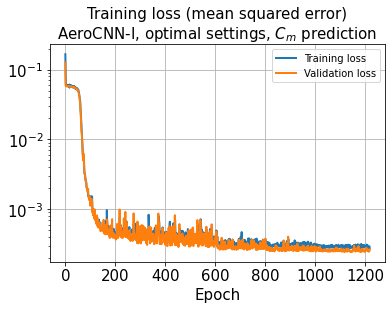

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

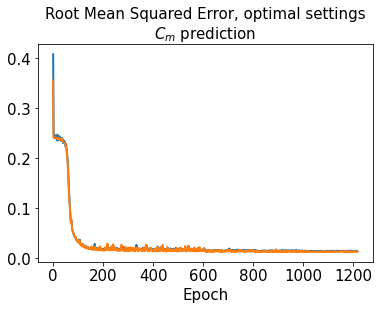

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

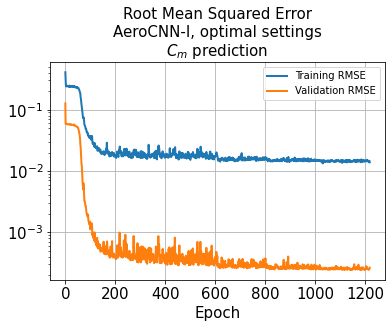

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 4ms/step - loss: 2.8719e-04 - rmse: 0.0143


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 4ms/step - loss: 2.4927e-04 - rmse: 0.0129


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 5ms/step - loss: 2.5866e-04 - rmse: 0.0132


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 2ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.03276289962891368
1.2791269166631445


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.030123847322930584
1.2024208377913186


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.029287654985769764
1.148223015009261


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230unsteady_AeroCNN1_3Case(131415)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

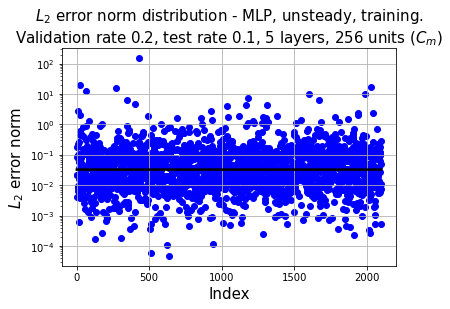

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

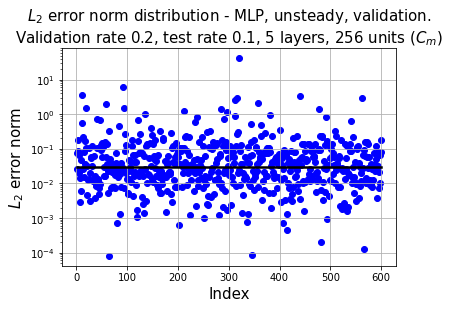

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

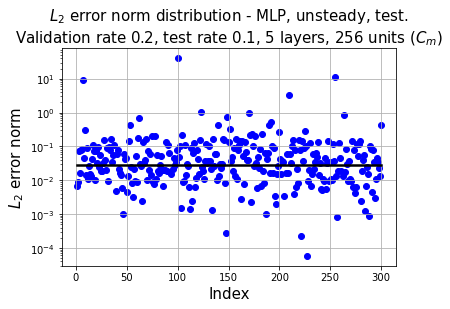

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 3ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.9912146], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.03191002769088885


In [67]:
cm[2000]

array([0.00682824])

In [68]:
cm[1000]

array([0.0014248])

In [69]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [71]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [72]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [73]:
len(predicted[index_train])

2100

In [74]:
len(predicted[index_val])

601

In [75]:
len(predicted[index_test])

301

In [76]:
x_time += 10

L2 error of Cm: 0.0338


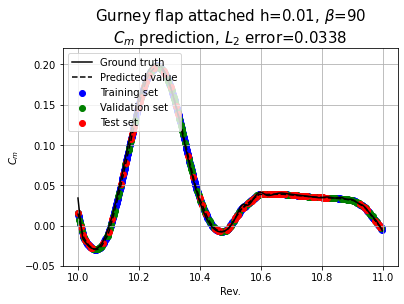

L2 error of Cm: 0.0391


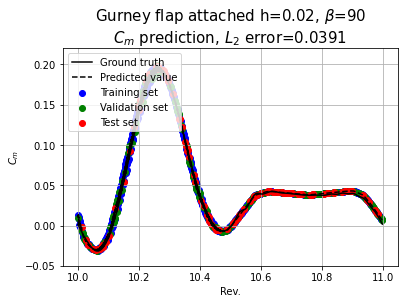

L2 error of Cm: 0.0186


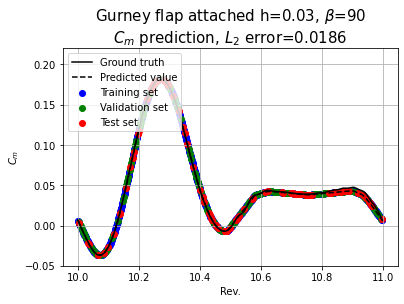

In [77]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [78]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0338


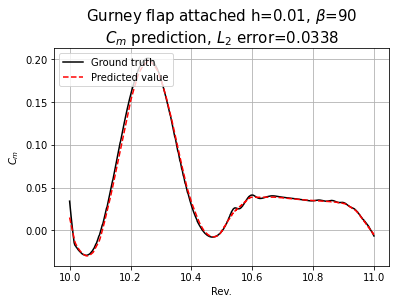

L2 error of Cm: 0.0391


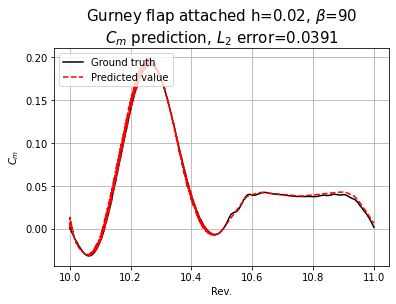

L2 error of Cm: 0.0186


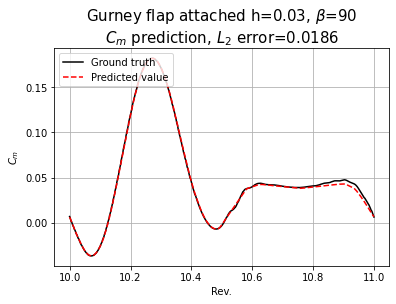

In [79]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0338


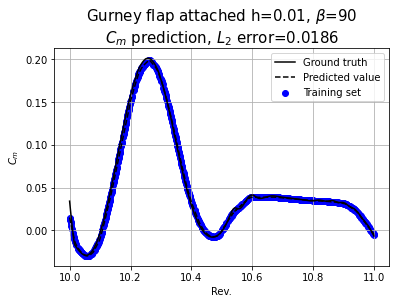

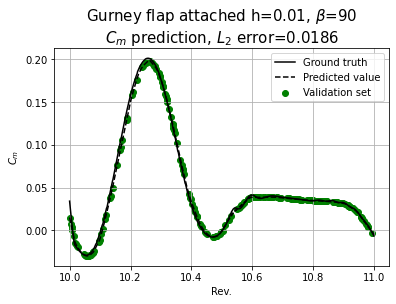

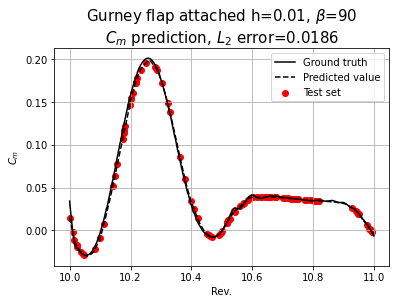

L2 error of Cm: 0.0391


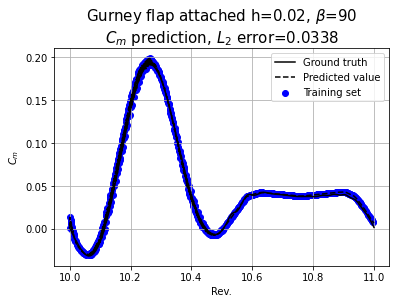

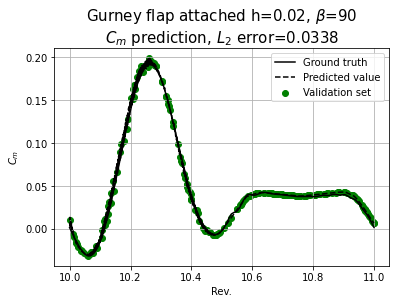

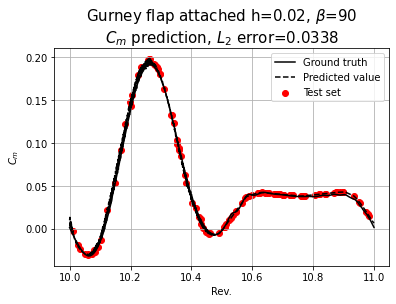

L2 error of Cm: 0.0186


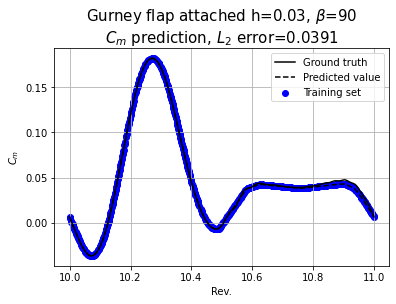

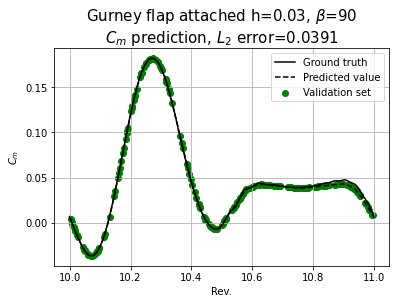

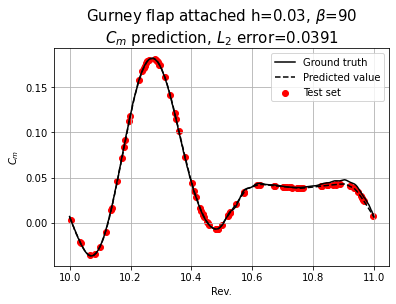

In [80]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

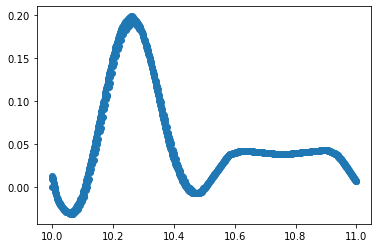

In [81]:
plt.scatter(t[:1000], denormalize(predicted[1000:2000]),  label='Predicted value')